In [11]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, \
f1_score, log_loss,plot_confusion_matrix, confusion_matrix

from typing import Tuple, Text

import joblib

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from typing import Dict

import yaml

import warnings
warnings.filterwarnings("ignore")

# Описание задачи

https://www.kaggle.com/competitions/GiveMeSomeCredit/data


Банки играют решающую роль в рыночной экономике. Они решают, кто может получить финансирование и на каких условиях, а также могут принимать или отменять инвестиционные решения. Чтобы рынки и общество функционировали, отдельным лицам и компаниям необходим доступ к кредитам. 

Алгоритмы кредитного скоринга, которые предполагают вероятность дефолта, — это метод, который банки используют для определения того, следует ли предоставлять кредит. Этот конкурс требует, чтобы участники улучшили состояние дел в кредитном скоринге, предсказывая вероятность того, что кто-то испытает финансовые затруднения в следующие два года.

**Цель:**
Целью этого конкурса является создание модели, которую заемщики смогут использовать для принятия наилучших финансовых решений.


## Описания полей 


**Target** -SeriousDlqin2yrs

- Unnamed: 0 -- Индексная колонка, представляющая уникальный идентификатор каждой записи.
- SeriousDlqin2yrs -- Бинарный признак, указывающий, имел ли заемщик серьезную просрочку платежей в течение двух лет.    Значение 1 означает наличие просрочки, а значение 0 - отсутствие просрочки.
- RevolvingUtilizationOfUnsecuredLines -- Доля использования необеспеченных кредитных линий. Это отношение суммы задолженности по кредитным картам к лимитам по кредитным картам.
- Аge -- Возраст заемщика.
- NumberOfTime30-59DaysPastDueNotWorse -- Количество раз, когда заемщик имел просрочку платежей на 30-59 дней, но не хуже.
- DebtRatio -- Соотношение долга к доходу заемщика.
- MonthlyIncome -- Ежемесячный доход заемщика.
- NumberOfOpenCreditLinesAndLoans -- Общее количество открытых кредитных линий и кредитов.
- NumberOfTimes90DaysLate -- Количество раз, когда заемщик имел просрочку платежей на 90+ дней.
- NumberRealEstateLoansOrLines -- Количество ипотечных кредитов и кредитных линий на недвижимость.
- NumberOfTime60-89DaysPastDueNotWorse -- Количество раз, когда заемщик имел просрочку платежей на 60-89 дней, но не хуже.
- NumberOfDependents -- Количество иждивенцев заемщика (супруг, дети и т.д.).
- Probalility -- Веротяность
- Id -- Id клиентов

In [12]:
sns.__version__

'0.11.2'

In [13]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader = yaml.FullLoader)

preproc = config['preprocessing']
training = config['train']

In [14]:
preproc

{'map_bins_columns': {'age': [35, 60],
  'MonthlyIncome': [4000, 8000],
  'NumberOfDependents': [0, 6]},
 'drop_columns': ['id'],
 'train_path': '../data/raw/train.csv',
 'unique_values_path': '../data/processed/unique_values.json',
 'train_path_proc': '../data/processed/train.csv',
 'test_path_proc': '../data/processed/test.csv',
 'test_size': 0.25,
 'target_column': 'SeriousDlqin2yrs',
 'random_state': 10}

In [15]:
training

{'n_trials': 10,
 'n_folds': 5,
 'random_state': 10,
 'target_column': 'SeriousDlqin2yrs',
 'model_path': '../models/model_lgb.joblib',
 'study_path': '../models/study.joblib',
 'metrics_path': '../report/metrics.json',
 'params_path': '../report/best_params.json'}

In [16]:
config['preprocessing']['map_bins_columns']

{'age': [35, 60], 'MonthlyIncome': [4000, 8000], 'NumberOfDependents': [0, 6]}

# EDA

### Загрузка данных

- Трениовачные данные

In [81]:
data_train = pd.read_csv(r"C:\Users\User\OneDrive - БФУ им. И. Канта\Рабочий стол\mlops-frontend-backend-docker-compose\data\processed\train.csv")


In [82]:
data_train


,id,SeriousDlqin2yrs,Revolving,age,NumberOfTime30,DebtRatio,MonthlyIncome,NumberOfOpen,NumberOfTimes90,NumberRealEstate,NumberOfTime60,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [133]:
dict(data.iloc[0])

{'id': 1,
 'SeriousDlqin2yrs': 1,
 'Revolving': 0.766126609,
 'age': 45,
 'NumberOfTime30': 2,
 'DebtRatio': 0.802982129,
 'MonthlyIncome': 9120.0,
 'NumberOfOpen': 13,
 'NumberOfTimes90': 0,
 'NumberRealEstate': 6,
 'NumberOfTime60': 0,
 'NumberOfDependents': 2.0,
 'age_bins': 'medium',
 'MonthlyIncome_bins': 'large',
 'NumberOfDependents_bins': 'medium'}

In [79]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112500 entries, 0 to 112499
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SeriousDlqin2yrs         112500 non-null  int64  
 1   Revolving                112500 non-null  float64
 2   age                      112500 non-null  int64  
 3   NumberOfTime30           112500 non-null  int64  
 4   DebtRatio                112500 non-null  float64
 5   MonthlyIncome            90220 non-null   float64
 6   NumberOfOpen             112500 non-null  int64  
 7   NumberOfTimes90          112500 non-null  int64  
 8   NumberRealEstate         112500 non-null  int64  
 9   NumberOfTime60           112500 non-null  int64  
 10  NumberOfDependents       109545 non-null  float64
 11  age_bins                 112500 non-null  object 
 12  MonthlyIncome_bins       112500 non-null  object 
 13  NumberOfDependents_bins  112500 non-null  object 
dtypes: f

- Тестовые данные

In [10]:
df_test = pd.read_csv(r"C:\Users\User\OneDrive - БФУ им. И. Канта\Рабочий стол\соревнования\test.csv")

- Записи вероятностей

In [11]:
df_sample = pd.read_csv(r"C:\Users\User\OneDrive - БФУ им. И. Канта\Рабочий стол\соревнования\sampleEntry.csv")

In [12]:
df_sample

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264
...,...,...
101498,101499,0.045363
101499,101500,0.343775
101500,101501,0.006970
101501,101502,0.121994


### Информация о данных

In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [15]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           101503 non-null  int64  
 1   Probability  101503 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


### Анализ пропусков

In [16]:
data_train.isna().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [16]:
df_test.isna().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [18]:
df_sample.isna().sum()

Id             0
Probability    0
dtype: int64

### Доля пропусков

In [20]:
print(
    f'Доля пропусков:{round(data_train.isna().sum() / df_train.shape[0]*100,2)}%'
)

Доля пропусков:Unnamed: 0                               0.00
SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           19.82
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       2.62
dtype: float64%


In [22]:
print(
    f'Доля пропусков:{round(df_test.isna().sum() / df_test.shape[0]*100, 2)}%' 
)

Доля пропусков:Unnamed: 0                                0.00
SeriousDlqin2yrs                        100.00
RevolvingUtilizationOfUnsecuredLines      0.00
age                                       0.00
NumberOfTime30-59DaysPastDueNotWorse      0.00
DebtRatio                                 0.00
MonthlyIncome                            19.81
NumberOfOpenCreditLinesAndLoans           0.00
NumberOfTimes90DaysLate                   0.00
NumberRealEstateLoansOrLines              0.00
NumberOfTime60-89DaysPastDueNotWorse      0.00
NumberOfDependents                        2.59
dtype: float64%


### Уникальныйе значения

- Сохраняем уникальные значения

In [83]:
def save_unique_train_data(
    data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для вывода в UI
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [84]:
preproc["unique_values_path"]

'../data/processed/unique_values.json'

In [85]:
save_unique_train_data(
    data=data_train,
    drop_columns=preproc["drop_columns"],
    target_column=preproc["target_column"],
    unique_values_path=preproc["unique_values_path"],
)

In [76]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  150000 non-null  int64  
 1   SeriousDlqin2yrs    150000 non-null  int64  
 2   Revolving           150000 non-null  float64
 3   age                 150000 non-null  int64  
 4   NumberOfTime30      150000 non-null  int64  
 5   DebtRatio           150000 non-null  float64
 6   MonthlyIncome       120269 non-null  float64
 7   NumberOfOpen        150000 non-null  int64  
 8   NumberOfTimes90     150000 non-null  int64  
 9   NumberRealEstate    150000 non-null  int64  
 10  NumberOfTime60      150000 non-null  int64  
 11  NumberOfDependents  146076 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


- Трениовачный набор данных

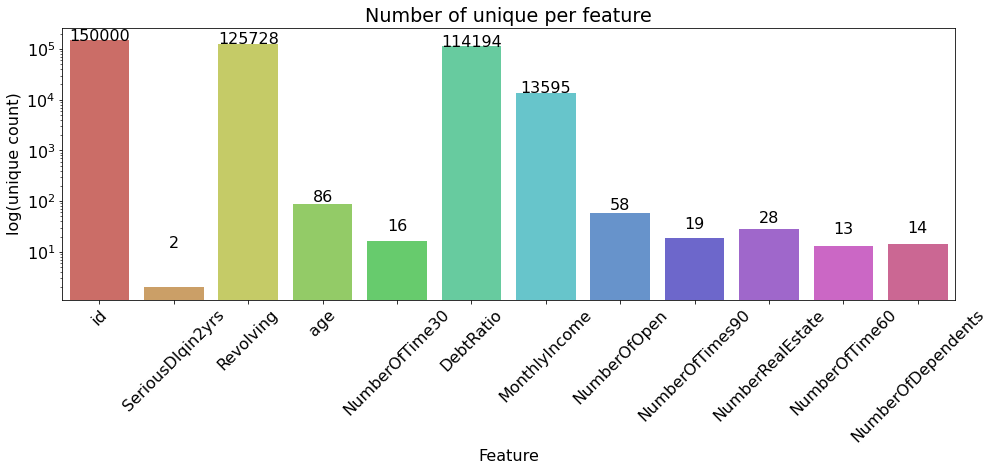

In [77]:
plt.figure(figsize=(16,5))

cols = data_train.columns
uniques = [len(data_train[col].unique()) for col in cols]

ax = sns.barplot(x=cols , y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)',title = 'Number of unique per feature')

for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq +10,
            uniq,
            ha="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


- Тестовый набор данных

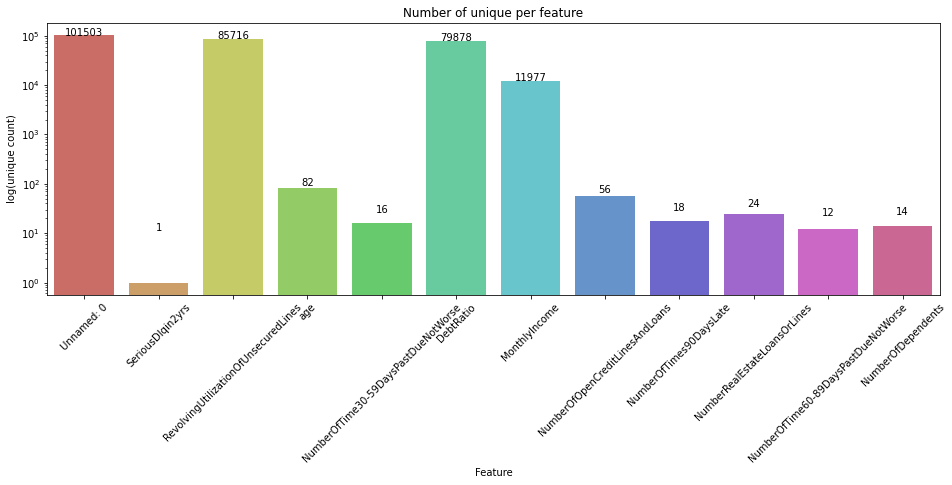

In [29]:
plt.figure(figsize=(16,5))

cols = df_test.columns
uniques = [len(df_test[col].unique()) for col in cols]

ax = sns.barplot(x=cols , y=uniques, palette='hls', log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)',title = 'Number of unique per feature')

for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq +10,
            uniq,
            ha="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

## Описательные статистки

- Тренеровачный набор данных

In [181]:
data_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


- Тестовый набор данных

In [32]:
df_test.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,50752.000000,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,29301.536524,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,1.000000,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25376.500000,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,50752.000000,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,76127.500000,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,101503.000000,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


### Анализ целевой переменной

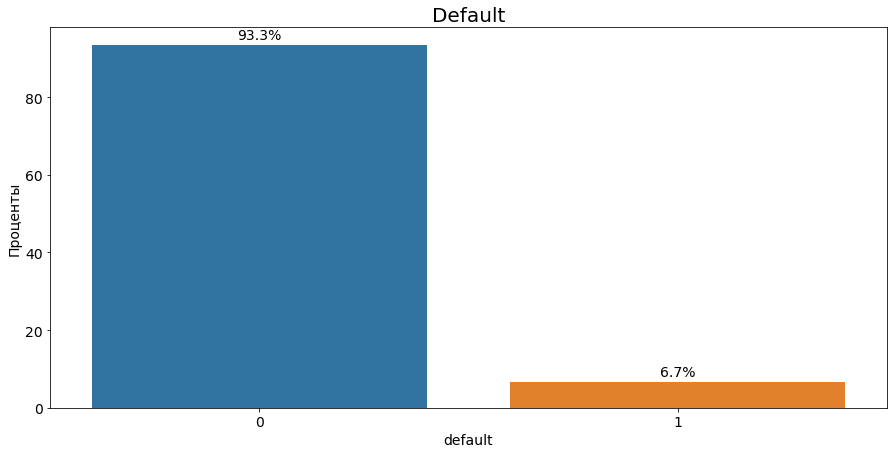

In [183]:
# нормирование на размер датасета
norm_target = (data_train. SeriousDlqin2yrs.value_counts(
    normalize=True).mul(100).rename('percent').reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,  # текст
        # координата xy
        (p.get_x() + p.get_width() / 2., p.get_height()),
        # центрирование
        ha='center',
        va='center',
        xytext=(0, 10),
        # точка смещения относительно координаты
        textcoords='offset points',
        fontsize=14)

plt.title('Default', fontsize=20)
plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [184]:
class0 = data_train['SeriousDlqin2yrs'].value_counts()[0]
class1 = data_train['SeriousDlqin2yrs'].value_counts()[1]
print("class 0 : {}".format(class0))
print("class 1 : {}".format(class1))
print("Уровень просроченной задолжнности".format(class1/(class0+class1)))

class 0 : 139974
class 1 : 10026
Уровень просроченной задолжнности


**Вывод**
- Мы выдим что у нас очень сильный дисбаланс классов, **при обучении модели это стоит учитывать**.

#### Анализ целевой перемнной в разрезе осноных признаков

<AxesSubplot:xlabel='age', ylabel='Density'>

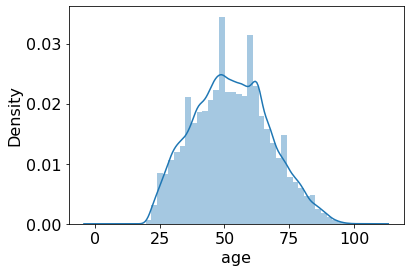

In [185]:
sns.distplot(data_train.loc[df_train['SeriousDlqin2yrs'] == 0]['age'])

<AxesSubplot:xlabel='age', ylabel='Density'>

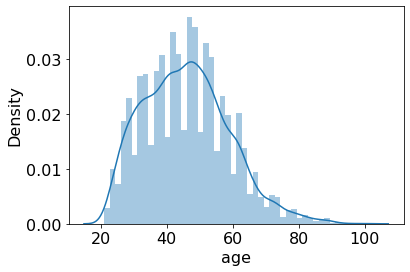

In [186]:
sns.distplot(data_train.loc[df_train['SeriousDlqin2yrs'] == 1]['age'])

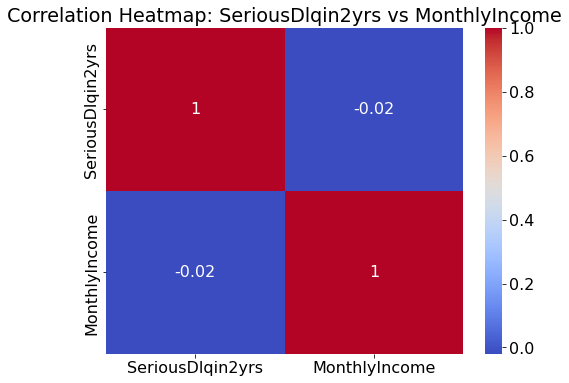

In [187]:
# Выбор двух переменных для первой гипотезы
var1 = 'SeriousDlqin2yrs'
var2 = 'MonthlyIncome'

# Создание матрицы корреляции
correlation_matrix = data_train[[var1, var2]].corr()

# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Настройка заголовка
plt.title('Correlation Heatmap: {} vs {}'.format(var1, var2))

# Показать тепловую карту
plt.show()


## Анализ распределений и линейных зависимотей

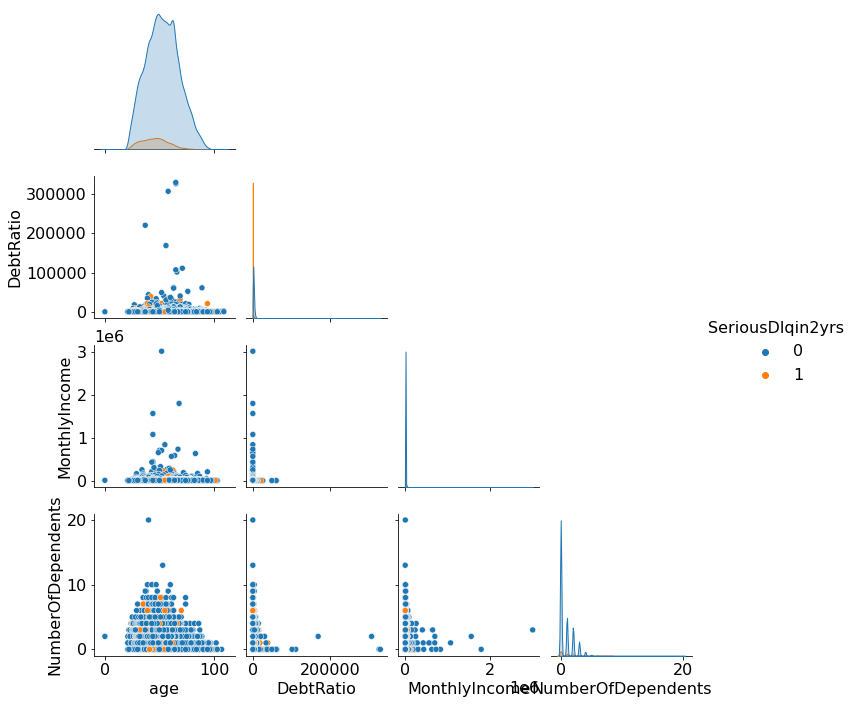

In [188]:
features = [
    'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfDependents'
]

sns.pairplot(data_train, vars=features, hue='SeriousDlqin2yrs', corner=True)
plt.show()

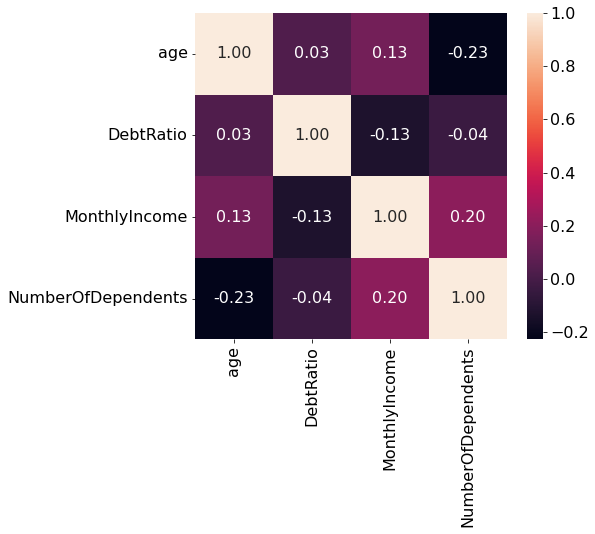

In [189]:
plt.figure(figsize=(7, 6))
sns.heatmap(data_train[features].corr(method='spearman'), annot=True, fmt='.2f');

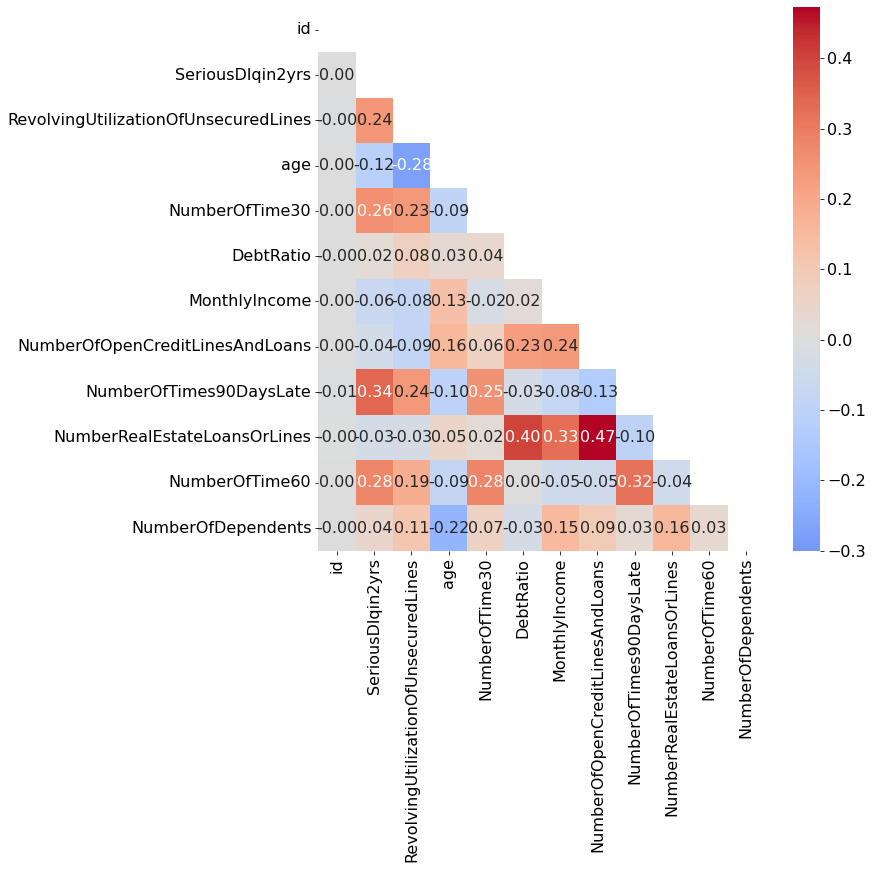

In [190]:
"""
fmt - кол-во знаков после запятой
vmin - масштаб шкалы min значение
vmax - масштаб шкалы max значение
center - центр
cmap - цветовая схема
np.tril() - маска значений выше главной диагонали
np.triu() - маска значений ниже главной диагонали
"""
matrix = np.triu(df_train.corr(method='spearman'))

plt.figure(figsize=(10, 10))

sns.heatmap(df_train.corr(method='spearman'), annot=True,
            fmt='.2f', vmin=-0.3, center=0, cmap='coolwarm', mask=matrix);

# Проверка Гипотез

In [191]:
def barplot_group(col_main: str, col_group: str, title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """
    
    plt.figure(figsize=(15, 6))

    data = (data_train.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage", hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

### Гипотеза №1

Возраст "хорших" заемщиков больше, по сравнению с "плохими"(распределния возраста в зависимости от флага дефолта смещено в большую строну при Targe =0),возратные более платежеспособные

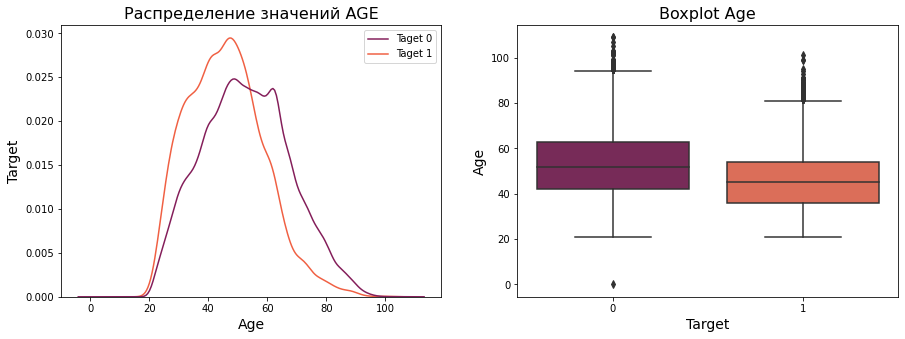

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot(
    data={
        "Taget 0": df_train[df_train.SeriousDlqin2yrs == 0].age,
        "Taget 1": df_train[df_train.SeriousDlqin2yrs == 1].age
    },
    common_norm=False,
    palette='rocket',
    ax=axes[0])

axes[0].set_title('Распределение значений AGE', fontsize=16)
axes[0].set_xlabel('Age', fontsize=14)
axes[0].set_ylabel('Target', fontsize=14)

sns.boxplot(x='SeriousDlqin2yrs', y='age', data=df_train, palette='rocket', ax=axes[1])

axes[1].set_title('Boxplot Age', fontsize=16)
axes[1].set_ylabel('Age', fontsize=14)
axes[1].set_xlabel('Target', fontsize=14)
plt.show()

**Вывод**
- Вывод по данной гипотезы, тем страше люди тем боллее они платежоспособны.

### Гипотеза №2

Высокая доля использования необеспеченных кредитных линий (RevolvingUtilizationOfUnsecuredLines) связана с большей вероятностью серьезной просрочки платежей (SeriousDlqin2yrs). Пользователи, у которых сумма задолженности по кредитным картам близка или превышает предоставленные кредитные лимиты, могут испытывать трудности с возвратом долга.

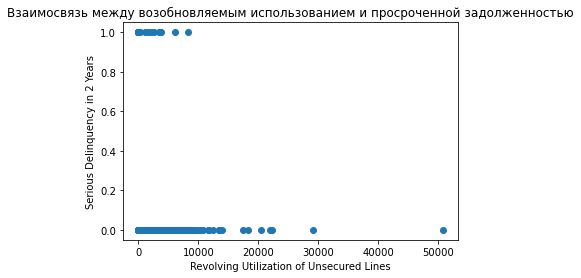

In [64]:
# Выделение признаков и целевой переменной
X = data_train['Revolving']
y = data_train['SeriousDlqin2yrs']

# Создание диаграммы разброса
plt.scatter(X, y)
plt.xlabel('Revolving Utilization of Unsecured Lines')
plt.ylabel('Serious Delinquency in 2 Years')
plt.title('Взаимосвязь между возобновляемым использованием и просроченной задолженностью')
plt.show()

- Визуальный анализ показывает, что существует некоторая связь между долей использования необеспеченных кредитных линий и серьезной просрочкой платежей. Заемщики с более высокой долей использования необеспеченных кредитных линий (близкой к 1) имеют большую вероятность столкнуться с серьезной просрочкой платежей. С другой стороны, заемщики с более низкой долей использования необеспеченных кредитных линий (близкой к 0) имеют меньшую вероятность серьезной просрочки платежей.

### Гипотеза №3

- Большее количество иждивенцев (NumberOfDependents) может быть связано с более низкой вероятностью серьезной просрочки платежей. Заемщики с семейными обязательствами могут быть более ответственными и стараться выполнять свои финансовые обязательства.

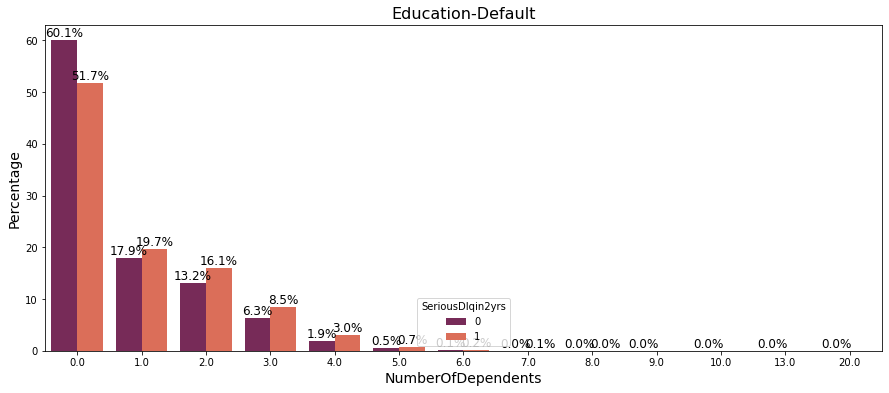

In [66]:
barplot_group("NumberOfDependents", "SeriousDlqin2yrs", 'Dependts-Target')

**Вывод**
- Гипотеза потвердилась , люди у которых есть семейные обязательства болле отвествные и страяются выполнять свои обязательства.

### Гипотеза №4

- Наличие ипотечных кредитов и кредитных линий на недвижимость (NumberRealEstateLoansOrLines) может указывать на более надежных заемщиков с меньшей вероятностью серьезной просрочки платежей. Имущество может служить в качестве обеспечения и повышать ответственность заемщика. Визалзуруй данную гипотезу

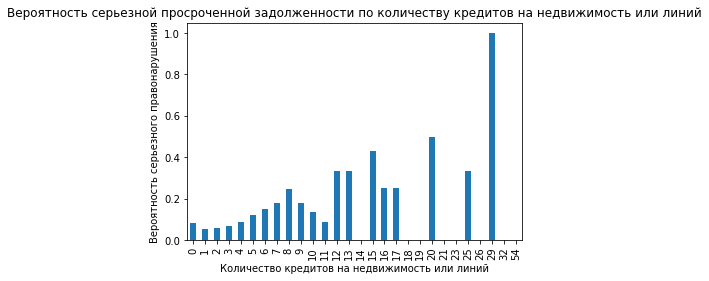

In [72]:
н# Группировка данных по наличию ипотечных кредитов и кредитных линий на недвижимость
grouped_data = data_train.groupby('NumberRealEstateLoansOrLines')['SeriousDlqin2yrs'].mean()

# Создание столбчатой диаграммы
grouped_data.plot(kind='bar')
plt.xlabel('Количество кредитов на недвижимость или линий')
plt.ylabel('Вероятность серьезного правонарушения')
plt.title('Вероятность серьезной просроченной задолженности по количеству кредитов на недвижимость или линий')
plt.show()

**Вывод**
- Диаграмма показывает, что заемщики с наличием ипотечных кредитов и кредитных линий на недвижимость (NumberRealEstateLoansOrLines) имеют более низкую вероятность серьезной просрочки платежей. Заемщики с большим количеством ипотечных кредитов и кредитных линий на недвижимость обычно являются более надежными и ответственными плательщиками. Возможно, наличие недвижимости в качестве обеспечения повышает их финансовую ответственность и способность выполнять финансовые обязательства своевременно.

## Feature engineering

In [26]:
data_train[:4]

,id,SeriousDlqin2yrs,Revolving,age,NumberOfTime30,DebtRatio,MonthlyIncome,NumberOfOpen,NumberOfTimes90,NumberRealEstate,NumberOfTime60,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0


In [86]:
def get_bins(data:(int, float), first_val:(int, float),
             second_val: (int, float)) -> str:
    """ 
    Генерация бинов для разных признаков
    :param data:датасет
    :param first_val: первый порог значения для разбиения на бины
    :param second_val: второй порог значения для разбиения на бины
    :return:датасет
    """
    assert isinstance(data,(int,float)),"Проблема с типом данных в признаке"
    result = ("small" if data <= first_val else
              "medium" if first_val < data <= second_val else "large")
    return result

In [87]:
preproc["map_bins_columns"]

{'age': [35, 60], 'MonthlyIncome': [4000, 8000], 'NumberOfDependents': [0, 6]}

In [88]:
for key in preproc["map_bins_columns"].keys():
    data_train[f"{key}_bins"] = data_train[key].apply(lambda x: get_bins(
    x,
    first_val=preproc["map_bins_columns"][key][0],
    second_val=preproc["map_bins_columns"][key][1],
    ))
    

In [89]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       150000 non-null  int64  
 1   SeriousDlqin2yrs         150000 non-null  int64  
 2   Revolving                150000 non-null  float64
 3   age                      150000 non-null  int64  
 4   NumberOfTime30           150000 non-null  int64  
 5   DebtRatio                150000 non-null  float64
 6   MonthlyIncome            120269 non-null  float64
 7   NumberOfOpen             150000 non-null  int64  
 8   NumberOfTimes90          150000 non-null  int64  
 9   NumberRealEstate         150000 non-null  int64  
 10  NumberOfTime60           150000 non-null  int64  
 11  NumberOfDependents       146076 non-null  float64
 12  age_bins                 150000 non-null  object 
 13  MonthlyIncome_bins       150000 non-null  object 
 14  Numb

- Переменнуем столбец 'Unnamed: 0', 'NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse' для удобства

- Заполнеяи пропуски в стобцах 

In [90]:
mean_M = data_train['MonthlyIncome'].mean()
data_train = data_train.fillna({'MonthlyIncome': mean_M})

In [91]:
mean_N = data_train['NumberOfDependents'].mean()
data_train = data_train.fillna({'NumberOfDependents': mean_N})

In [92]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       150000 non-null  int64  
 1   SeriousDlqin2yrs         150000 non-null  int64  
 2   Revolving                150000 non-null  float64
 3   age                      150000 non-null  int64  
 4   NumberOfTime30           150000 non-null  int64  
 5   DebtRatio                150000 non-null  float64
 6   MonthlyIncome            150000 non-null  float64
 7   NumberOfOpen             150000 non-null  int64  
 8   NumberOfTimes90          150000 non-null  int64  
 9   NumberRealEstate         150000 non-null  int64  
 10  NumberOfTime60           150000 non-null  int64  
 11  NumberOfDependents       150000 non-null  float64
 12  age_bins                 150000 non-null  object 
 13  MonthlyIncome_bins       150000 non-null  object 
 14  Numb

In [102]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       150000 non-null  int64   
 1   SeriousDlqin2yrs         150000 non-null  int64   
 2   Revolving                150000 non-null  float64 
 3   age                      150000 non-null  int64   
 4   NumberOfTime30           150000 non-null  int64   
 5   DebtRatio                150000 non-null  float64 
 6   MonthlyIncome            150000 non-null  float64 
 7   NumberOfOpen             150000 non-null  int64   
 8   NumberOfTimes90          150000 non-null  int64   
 9   NumberRealEstate         150000 non-null  int64   
 10  NumberOfTime60           150000 non-null  int64   
 11  NumberOfDependents       150000 non-null  float64 
 12  age_bins                 150000 non-null  category
 13  MonthlyIncome_bins       150000 non-null  ca

In [93]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return:
    """
    return data.astype(change_type_columns, errors="raise")

In [101]:
dict_category = {
    key: "category"
    for key in data_train.select_dtypes(["object"]).columns
}
data_train = transform_types(data=data_train, change_type_columns=dict_category)

- Переводим тип object в category, так как используем LGBM

# Training

## Basline

In [103]:
preproc["drop_columns"][0]

'id'

In [104]:
training['target_column']

'SeriousDlqin2yrs'

In [105]:
X = data_train.drop(columns=[preproc['drop_columns'][0], training['target_column']], axis=1)
y = data_train[training['target_column']]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=preproc['test_size'],
    random_state=preproc['random_state'])

In [106]:
lgb = LGBMClassifier(random_state=training['random_state'], class_weight='balanced')
lgb.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=10)

In [107]:
def get_metrics(y_test: np.array, y_pred: np.array, y_proba: np.array) -> Dict:
    dict_metrics = {
        'roc_auc': round(roc_auc_score(y_test, y_proba[:, 1]), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'logloss': round(log_loss(y_test, y_proba), 3)
    }

    return dict_metrics

In [108]:
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)

result = get_metrics(y_test, y_pred, y_pred_proba)

print('roc-auc', result['roc_auc'])
print('precision', result['precision'])
print('recall', result['recall'])
print('f1', result['f1'])
print('logloss', result['logloss'])

roc-auc 0.865
precision 0.221
recall 0.765
f1 0.343
logloss 0.433


In [109]:
result

{'roc_auc': 0.865,
 'precision': 0.221,
 'recall': 0.765,
 'f1': 0.343,
 'logloss': 0.433}

## Tuning

In [110]:
for num in [100,200,300]:
    lgb = LGBMClassifier(class_weight='balanced',
                         random_state=training['random_state'],
                         n_estimators=num)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_test)
    y_pred_proba = lgb.predict_proba(X_test)
    
    result = get_metrics(y_test, y_pred, y_pred_proba)
    print(f"estimators_num = {num}, roc_auc={result['roc_auc']}")

estimators_num = 100, roc_auc=0.865
estimators_num = 200, roc_auc=0.862
estimators_num = 300, roc_auc=0.86


In [111]:
def objective(trial, X, y, N_FOLDS, RANDOM_STATE):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "random_state": trial.suggest_categorical("random_state", [RANDOM_STATE]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 4, 15, step=1),
        # регуляризация
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 100),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 100),
        "min_split_gain": trial.suggest_int("min_gain_to_split", 0, 20),
        # доля объектов при обучении в дереве
        "subsample": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "subsample_freq": trial.suggest_categorical("bagging_freq", [1]),
        # доля признаков при обучении в дереве
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "class_weight": trial.suggest_categorical("class_weight", ['balanced'])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True,
                         random_state=RANDOM_STATE)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")

        model = LGBMClassifier(**param_grid)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)
        
        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

In [112]:
training

{'n_trials': 10,
 'n_folds': 5,
 'random_state': 10,
 'target_column': 'SeriousDlqin2yrs',
 'model_path': '../models/model_lgb.joblib',
 'study_path': '../models/study.joblib',
 'metrics_path': '../report/metrics.json',
 'params_path': '../report/best_params.json'}

In [113]:
study = optuna.create_study(direction="maximize", study_name="LGB")
func = lambda trial: objective(trial, X_train, y_train, training['n_folds'],
                               training['random_state'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=training['n_trials'], show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [114]:
print(f"\tBest value (AUC)): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}:{value}")

	Best value (AUC)): 0.86363
	Best params:
		n_estimators:100
		random_state:10
		learning_rate:0.22293927521066975
		num_leaves:300
		max_depth:8
		lambda_l1:18
		lambda_l2:38
		min_gain_to_split:10
		bagging_fraction:0.5411907584134206
		bagging_freq:1
		colsample_bytree:0.9835013539743898
		class_weight:balanced


In [115]:
optuna.visualization.plot_param_importances(study)

In [116]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [117]:
study.best_params

{'n_estimators': 100,
 'random_state': 10,
 'learning_rate': 0.22293927521066975,
 'num_leaves': 300,
 'max_depth': 8,
 'lambda_l1': 18,
 'lambda_l2': 38,
 'min_gain_to_split': 10,
 'bagging_fraction': 0.5411907584134206,
 'bagging_freq': 1,
 'colsample_bytree': 0.9835013539743898,
 'class_weight': 'balanced'}

In [118]:
training['params_path']

'../report/best_params.json'

In [119]:
best_params = training['params_path']

with open(best_params, 'w') as f:
    json.dump(study.best_params, f)

## Train with best params

In [120]:
clf = LGBMClassifier(**study.best_params)
clf.fit(X_train, y_train, verbose=0)

LGBMClassifier(bagging_fraction=0.5411907584134206, bagging_freq=1,
               class_weight='balanced', colsample_bytree=0.9835013539743898,
               lambda_l1=18, lambda_l2=38, learning_rate=0.22293927521066975,
               max_depth=8, min_gain_to_split=10, num_leaves=300,
               random_state=10)

In [121]:
training

{'n_trials': 10,
 'n_folds': 5,
 'random_state': 10,
 'target_column': 'SeriousDlqin2yrs',
 'model_path': '../models/model_lgb.joblib',
 'study_path': '../models/study.joblib',
 'metrics_path': '../report/metrics.json',
 'params_path': '../report/best_params.json'}

In [122]:
training['model_path']

'../models/model_lgb.joblib'

In [123]:
model_path = training['model_path']

joblib.dump(clf,model_path)

['../models/model_lgb.joblib']

In [124]:
training['metrics_path']

'../report/metrics.json'

In [125]:
metrics_path = training['metrics_path']

metrics = get_metrics(y_test, clf.predict(X_test), clf.predict_proba(X_test))
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

In [126]:
with open(metrics_path) as json_file:
    metrics = json.load(json_file)
metrics

{'roc_auc': 0.866,
 'precision': 0.214,
 'recall': 0.781,
 'f1': 0.336,
 'logloss': 0.453}

In [127]:
get_metrics(y_test, lgb.predict(X_test), clf.predict_proba(X_test))

{'roc_auc': 0.866,
 'precision': 0.232,
 'recall': 0.729,
 'f1': 0.352,
 'logloss': 0.453}

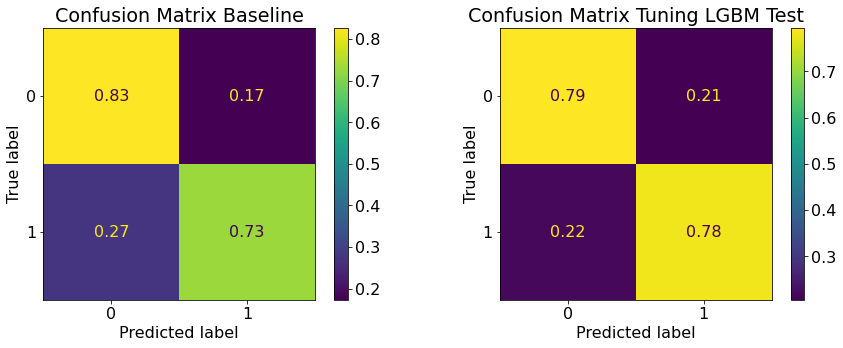

In [128]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(lgb, X_test, y_test, ax=ax[0], normalize='true');
ax[0].set_title('Confusion Matrix Baseline'); 
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_test, y_test, ax=ax[1], normalize='true');
ax[1].set_title('Confusion Matrix Tuning LGBM Test'); 

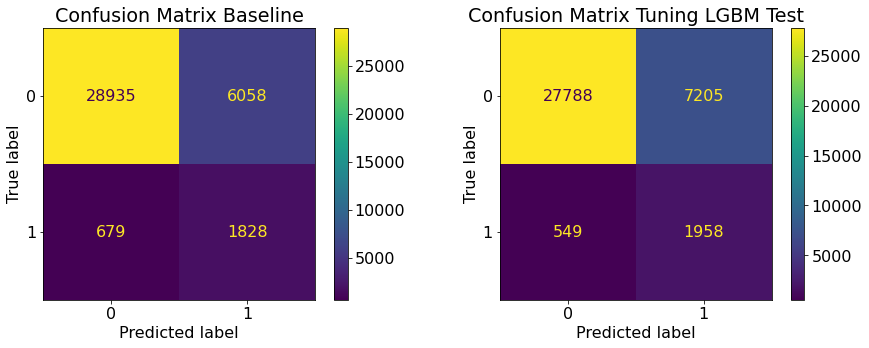

In [129]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(lgb, X_test, y_test, ax=ax[0]);
ax[0].set_title('Confusion Matrix Baseline'); 
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_test, y_test, ax=ax[1]);
ax[1].set_title('Confusion Matrix Tuning LGBM Test'); 

In [132]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37500 entries, 73575 to 18070
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Revolving                37500 non-null  float64 
 1   age                      37500 non-null  int64   
 2   NumberOfTime30           37500 non-null  int64   
 3   DebtRatio                37500 non-null  float64 
 4   MonthlyIncome            37500 non-null  float64 
 5   NumberOfOpen             37500 non-null  int64   
 6   NumberOfTimes90          37500 non-null  int64   
 7   NumberRealEstate         37500 non-null  int64   
 8   NumberOfTime60           37500 non-null  int64   
 9   NumberOfDependents       37500 non-null  float64 
 10  age_bins                 37500 non-null  category
 11  MonthlyIncome_bins       37500 non-null  category
 12  NumberOfDependents_bins  37500 non-null  category
dtypes: category(3), float64(4), int64(6)
memory usage: 3.3 MB

# Finance (сравнение с бейзлайном)

In [66]:
def predict_credit_default(model, X_test, y_test):
    # Предсказываем вероятность дефолта с помощью модели
    probability = model.predict_proba(X_test)[:, 1]

    # Определяем прогноз кредитного дефолта на основании вероятности
    credit_default = probability >= 0.5

    # Вычисляем точность прогноза
    accuracy = (credit_default == y_test).mean()

    # Вычисляем разницу точности с предыдущей моделью в процентах
    prev_accuracy =0.865  # Точность предыдущей модели (замените на реальное значение)
    percent_delta = round((accuracy - prev_accuracy) * 100, 1)

    # Возвращаем прогноз кредитного дефолта, вероятность, точность и разницу в процентах
    return credit_default, probability, accuracy, percent_delta

In [67]:
y_test.shape

(37500,)

In [68]:
predict_credit_default(lgb, X_test, y_test)

(array([False, False, False, ...,  True, False, False]),
 array([0.00165652, 0.37189271, 0.23841187, ..., 0.98895312, 0.3559898 ,
        0.15142435]),
 0.8203466666666667,
 -4.5)

In [69]:
predict_credit_default(clf, X_test, y_test)

(array([False, False, False, ...,  True, False,  True]),
 array([0.06083039, 0.4445488 , 0.42681669, ..., 0.96595045, 0.30200829,
        0.60903535]),
 0.7953866666666667,
 -7.0)

In [70]:
credit_default_clf, probability_clf, accuracy_clf, percent_delta_clf = predict_credit_default(clf, X_test, y_test)
credit_default_lgb, probability_lgb, accuracy_lgb, percent_delta_lgb = predict_credit_default(lgb, X_test, y_test)

print(f'разница в точности моделей в % = {percent_delta_clf}%')

разница в точности моделей в % = -7.0%
